In [27]:
from data.data_handler import Data, SimpleDataset
from models.simple import Simple
from models.conv import Conv
from trainer import Trainer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [28]:
use_cuda = False#torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [29]:
data_dir = "data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")
# stocks= stocks.groupby("Date").filter(lambda x: x["Isin"].count() > 100)
# # rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
# # cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
# # index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
# # Y = rates.join(cmdty).join(index)
# stocks = stocks.pivot(index="Date", columns = "Isin", values="Close")
# stocks.index = pd.to_datetime(stocks.index)
# stocks = stocks.resample("W-Fri").first()
# X = stocks.pct_change().dropna(how="all")
# X[X == 0.0] = np.nan
# X = X.loc[:, X.count() > 100]
# mu = X.mean()
# std = X.std()
# X = X.sub(mu, axis=1).div(std, axis=1)

In [30]:
df = stocks.copy().set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan
mu = df.mean()
std = df.std()

In [31]:
rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
Y = rates.join(cmdty).join(index).pct_change()[1:]
Y = Y.reindex(df.index).fillna(0.0)

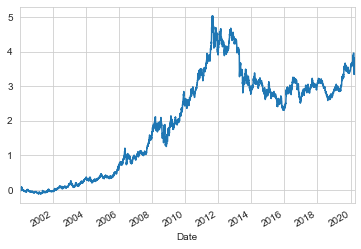

In [33]:
((1.0 + Y["Gold"]).cumprod()-1).plot()
Y = Y[["US10", "SWE10", "NOR10", "Oil", "HEX", "OBX", "OMX", "OMXC"]]

In [64]:
T = 50
n = 5

scaler = StandardScaler()

X = []
steps = len(df) // T
windows = 100

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].dropna(axis=1)
    #df_t = df_t.sub(df_t.mean(), axis=1).div(df_t.std(), axis=1).dropna(axis=1)
    
    if df_t.shape[1] < n:
        continue
    for _ in range(windows):
        i = np.random.choice(np.arange(df_t.shape[1]), n, replace=False)
        df_t_i = df_t.iloc[:,i]
        #df_t_i = df_t_i.sub(df_t_i.mean(), axis=1).div(df_t_i.std(), axis=1)
        X.append(df_t_i.values.reshape(-1,1).squeeze())
    
    

X = np.array(X)
X.shape

(6200, 250)

In [65]:

train, test = train_test_split(X, test_size = 0.1, random_state = 42)
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train.shape, test.shape

((5580, 250), (620, 250))

In [66]:
train_data = SimpleDataset(torch.from_numpy(train))
test_data = SimpleDataset(torch.from_numpy(test))


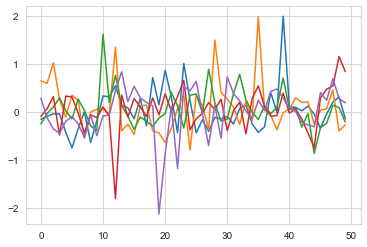

In [67]:
x = test_data[0].reshape(n,T).T
_ = plt.plot(x)

In [68]:

n_z = 64
#train_data = Data(T, n, 1000)
#test_data = Data(T, n, 200)
print(T,n,n_z)
vae = Simple(T, n, n_z)
#vae = Conv(T, n, n_z)

50 5 64


In [69]:
t = Trainer(vae, train_data, test_data, use_cuda)

In [100]:
losses = t.fit(200, burn_in = 0)

Epoch: 0, Train Loss: 103.32, Test Loss:  117.14
Epoch: 10, Train Loss: 109.06, Test Loss:  122.93
Epoch   211: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 20, Train Loss: 104.30, Test Loss:  121.16
Epoch   222: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 30, Train Loss: 103.77, Test Loss:  120.91
Epoch   240: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 40, Train Loss: 103.58, Test Loss:  120.62
Epoch: 50, Train Loss: 103.52, Test Loss:  120.86
Epoch   251: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 60, Train Loss: 103.43, Test Loss:  120.83
Epoch   262: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 70, Train Loss: 103.44, Test Loss:  120.25
Epoch: 80, Train Loss: 103.45, Test Loss:  120.67
Epoch: 90, Train Loss: 103.57, Test Loss:  120.80
Epoch: 100, Train Loss: 103.60, Test Loss:  120.50
Epoch: 110, Train Loss: 103.32, Test Loss:  120.76
Epoch: 120, Train Loss: 103.73, Test Loss:  121.01
Epoch: 130, Train Loss: 103.84, Test L

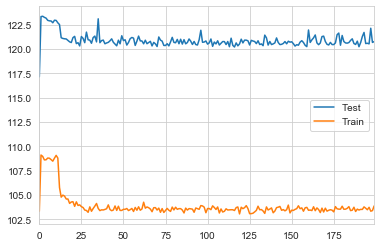

In [101]:
losses[losses < 1000].plot()

In [102]:
vae.eval()

Simple(
  (enc): Sequential(
    (0): Linear(in_features=250, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=250, out_features=125, bias=True)
    (4): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Latent(
      (mu): Linear(in_features=125, out_features=64, bias=True)
      (log_var): Linear(in_features=125, out_features=64, bias=True)
    )
  )
  (dec): Sequential(
    (0): Linear(in_features=64, out_features=125, bias=True)
    (1): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=125, out_features=250, bias=True)
    (4): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features

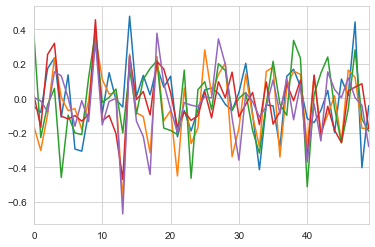

In [103]:
x1 = train_data[22].unsqueeze(0).to(device)
#x1 = torch.Tensor(x1.values).unsqueeze(0)
z, mu, log_var = vae.encode(x1)
gen_x = vae.decode(z).view(-1, T,n)
gen_x = pd.DataFrame(gen_x[0].cpu().detach().numpy())
gen_x.plot(legend=False)


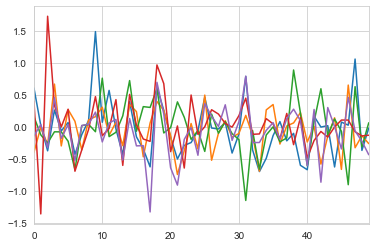

In [104]:
xx = pd.DataFrame(x1[0].cpu().detach().numpy().reshape(T,n))
xx.plot(legend=False)

5580
torch.Size([500, 250])
torch.Size([500, 64])


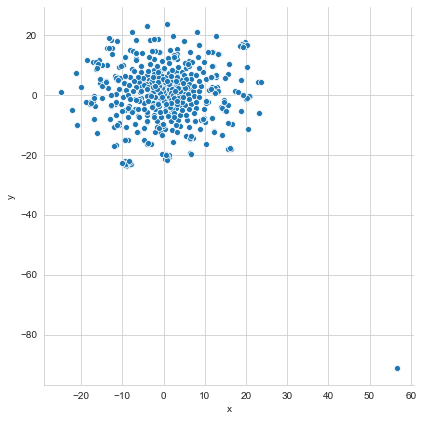

In [105]:
print(len(train_data))
idx = np.random.choice(np.arange(len(train_data)), 500, replace=False)
X = train_data[idx]
print(X.shape)
#X = X.view(X.size(0), X.size(2) * X.size(1))
X = X
Z1, mu, log_var = vae.encode(X.to(device))
print(Z1.shape)
l = Z1.cpu().detach().numpy()
l = TSNE(perplexity=40).fit_transform(l)
d = pd.DataFrame({"x": l[:,0], "y":l[:,1]})
g = sns.pairplot(x_vars="x", y_vars = "y", height=6, data=d)

# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 0])
# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 1])
# g = sns.pairplot(x_vars="x", y_vars = "y", hue="c",height=6, data=df[df.c == 2])
# Z1.shape

In [106]:
Z1.mean(dim=0), Z1.std(dim=0)**2

(tensor([ 0.0506, -0.1619, -0.0901, -0.0840, -0.0788, -0.0331, -0.0332,  0.0557,
         -0.0353,  0.0024, -0.0566,  0.0347,  0.1600, -0.1618, -0.0176, -0.0465,
          0.0419, -0.0796,  0.0622, -0.1136,  0.0096,  0.0692, -0.0438, -0.0178,
          0.0139, -0.0966, -0.0411, -0.0104, -0.0480, -0.0541, -0.0799,  0.1369,
          0.0202,  0.1261, -0.0642,  0.0033,  0.0577, -0.0756, -0.1101,  0.0683,
         -0.1256,  0.0332, -0.0174, -0.0052, -0.0182,  0.0107,  0.0288, -0.1045,
          0.0775, -0.0061,  0.1753, -0.0416,  0.1530, -0.0348,  0.0411,  0.0015,
          0.0249,  0.0373, -0.0531,  0.0292,  0.0640,  0.0239, -0.0170, -0.0557],
        grad_fn=<MeanBackward1>),
 tensor([1.1160, 1.3774, 1.0795, 1.3671, 1.0786, 1.3433, 1.3962, 1.3482, 1.2640,
         1.1030, 1.1828, 1.1669, 1.2694, 1.1888, 1.1105, 1.2574, 1.2049, 1.3427,
         1.2809, 1.2664, 1.1829, 1.2983, 1.1467, 1.2026, 1.1930, 1.1348, 1.0472,
         1.3274, 1.3672, 1.3817, 1.1440, 1.2242, 1.2468, 1.2805, 1.2397, 1

In [98]:
zz = torch.randn([1, n_z])
gen_x = vae.decode(zz)#.view(-1, n, T)
#gen_x = pd.DataFrame(gen_x[0].cpu().detach().numpy().T)
#(1.0 + gen_x/30).cumprod().plot(legend=False)
#pd.DataFrame(train_scaler.inverse_transform(gen_x.cpu().detach().numpy().reshape(-1,1).squeeze()).reshape(T,n)).plot(legend=False)
#gen_x = train_scaler.inverse_transform(gen_x[0].detach().numpy()).reshape(n,T).T
#_ = plt.plot(gen_x)

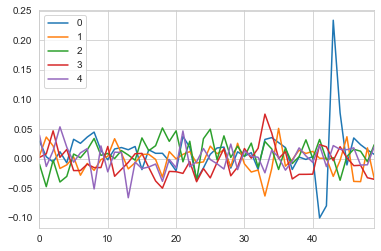

In [99]:
gen_x = pd.DataFrame(scaler.inverse_transform(gen_x[0].detach().numpy()).reshape(n,T).T)
(gen_x).plot()